In [1]:
import sys
import os
sys.path.append("../") 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from exploratory_data_analysis import omnivida_loader as ov
from exploratory_data_analysis import omnivida_util as ovu
import statsmodels.api         as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from io import StringIO
from IPython.display import Image, SVG
from graphviz import Source
from sklearn.tree import export_graphviz
import pydotplus
import xgboost as xgb
from xgboost import XGBClassifier

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
_, adherence_change = ov.get_adherence_dataset()
basic_info = ov.get_basic_info_dataset()
familiar_records = ov.get_family_records_dataset()
life_quality = ov.get_wellbeing_index_dataset()

In [3]:
basic_info2 = basic_info.copy()
basic_info2['education'] = basic_info2['education'].apply(lambda x: 0 if x < 'SECUNDARIA' else 1)

In [4]:
display(basic_info.head())
display(basic_info2.head())

id_patient   age gender        education civil_status  \
0      500547  58.0      M       SECUNDARIA   CASADO (A)   
1      500588  15.0      M         PRIMARIA  SOLTERO (A)   
2      502989  29.0      M    UNIVERSITARIO  SOLTERO (A)   
3      506808  11.0      M  EDAD PREESCOLAR  SOLTERO (A)   
4      512938  22.0      F       SECUNDARIA  SOLTERO (A)   

              department      city  social_stratum    zone  \
0              ANTIOQUIA  MEDELLIN             3.0  URBANA   
1  SANTAFE DE BOGOTA D.C    BOGOTA             2.0  URBANA   
2              ANTIOQUIA  MEDELLIN             3.0  URBANA   
3              ANTIOQUIA     BELLO             1.0  URBANA   
4              ANTIOQUIA  MEDELLIN             3.0  URBANA   

  socioeconomic_level   occupation social_security_regime  \
0                   A     EMPLEADO           CONTRIBUTIVO   
1                   B   ESTUDIANTE           CONTRIBUTIVO   
2                   A  SIN DEFINIR           CONTRIBUTIVO   
3                   A   ESTUDIANTE           CONTRIBUTIVO   
4                   A     EMPLEADO           CONTRIBUTIVO   

  social_security_affiliation_type  employment_type  birthdate  
0                        COTIZANTE         EMPLEADO 1962-05-19  
1                     BENEFICIARIO  MENOR NO LABORA 2004-12-19  
2                     BENEFICIARIO       SIN EMPLEO 1990-08-22  
3                     BENEFICIARIO  MENOR NO LABORA 2008-10-06  
4                        COTIZANTE         EMPLEADO 1997-10-15

id_patient   age gender  education civil_status             department  \
0      500547  58.0      M        1.0   CASADO (A)              ANTIOQUIA   
1      500588  15.0      M        0.0  SOLTERO (A)  SANTAFE DE BOGOTA D.C   
2      502989  29.0      M        1.0  SOLTERO (A)              ANTIOQUIA   
3      506808  11.0      M        0.0  SOLTERO (A)              ANTIOQUIA   
4      512938  22.0      F        1.0  SOLTERO (A)              ANTIOQUIA   

       city  social_stratum    zone socioeconomic_level   occupation  \
0  MEDELLIN             3.0  URBANA                   A     EMPLEADO   
1    BOGOTA             2.0  URBANA                   B   ESTUDIANTE   
2  MEDELLIN             3.0  URBANA                   A  SIN DEFINIR   
3     BELLO             1.0  URBANA                   A   ESTUDIANTE   
4  MEDELLIN             3.0  URBANA                   A     EMPLEADO   

  social_security_regime social_security_affiliation_type  employment_type  \
0           CONTRIBUTIVO                        COTIZANTE         EMPLEADO   
1           CONTRIBUTIVO                     BENEFICIARIO  MENOR NO LABORA   
2           CONTRIBUTIVO                     BENEFICIARIO       SIN EMPLEO   
3           CONTRIBUTIVO                     BENEFICIARIO  MENOR NO LABORA   
4           CONTRIBUTIVO                        COTIZANTE         EMPLEADO   

   birthdate  
0 1962-05-19  
1 2004-12-19  
2 1990-08-22  
3 2008-10-06  
4 1997-10-15

In [5]:
occupation_dict = {
    'DESEMPLEADO': 'DESEMPLEADO',
    'AMA DE CASA': 'AMA DE CASA',
    'EMPLEADO': 'EMPLEADO', 
    'ESTUDIANTE': 'ESTUDIANTE',
    'INDEPENDIENTE': 'EMPLEADO', 
    'JUBILADO': 'PENSIONADO',
    'PENSIONADO': 'PENSIONADO', 
    'SIN DEFINIR': 'SIN DEFINIR'
}

basic_info2['occupation'] = basic_info2['occupation'].apply(lambda x: occupation_dict[x]).astype('category')

In [6]:
basic_info2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872 entries, 0 to 871
Data columns (total 15 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id_patient                        872 non-null    int64         
 1   age                               872 non-null    float64       
 2   gender                            870 non-null    category      
 3   education                         862 non-null    float64       
 4   civil_status                      872 non-null    category      
 5   department                        872 non-null    object        
 6   city                              872 non-null    object        
 7   social_stratum                    872 non-null    float64       
 8   zone                              872 non-null    category      
 9   socioeconomic_level               860 non-null    category      
 10  occupation                        872 non-null    

In [7]:
select_fields = ['id_patient', 'survey_date', 'category', 'qualitative_result', 'qualitative_result_change', 'days_since_last_control', 'ongoing_adherence_percentage', 'num_reports']
adherence_change_analysis = adherence_change[select_fields]
adherence_change_analysis.head(30)

id_patient survey_date category  qualitative_result  \
0       500547  2016-07-11        A                 1.0   
1       500547  2019-03-14        A                 1.0   
2       500547  2019-10-11        A                 1.0   
3       500547  2019-12-09        A                 1.0   
4       500547  2020-01-16        A                 1.0   
5       500547  2020-03-25        A                 1.0   
6       500547  2020-05-08        A                 1.0   
7       500588  2019-04-26        A                 1.0   
8       502989  2014-08-22        M                 0.0   
9       502989  2014-10-28        M                 0.0   
10      502989  2014-11-21        M                 0.0   
11      502989  2015-01-07        M                 0.0   
12      502989  2015-01-14        M                 0.0   
13      502989  2015-06-25        M                 1.0   
14      502989  2016-01-12        M                 0.0   
15      502989  2016-01-15        M                 1.0   
16      502989  2017-01-03        M                 0.0   
17      502989  2017-03-21        M                 1.0   
18      502989  2017-07-10        M                 1.0   
19      502989  2017-08-08        M                 1.0   
20      502989  2018-10-03        M                 0.0   
21      502989  2019-02-08        M                 1.0   
22      506808  2013-05-08        M                 0.0   
23      506808  2013-05-24        M                 1.0   
24      506808  2013-09-11        M                 1.0   
25      506808  2013-10-02        M                 1.0   
26      506808  2014-09-30        M                 1.0   
27      506808  2014-12-16        M                 1.0   
28      506808  2015-02-05        M                 1.0   
29      506808  2015-02-14        M                 1.0   

    qualitative_result_change  days_since_last_control  \
0                         NaN                      NaN   
1                         0.0                    976.0   
2                         0.0                    211.0   
3                         0.0                     59.0   
4                         0.0                     38.0   
5                         0.0                     69.0   
6                         0.0                     44.0   
7                         NaN                      NaN   
8                         NaN                      NaN   
9                         0.0                     67.0   
10                        0.0                     24.0   
11                        0.0                     47.0   
12                        0.0                      7.0   
13                        1.0                    162.0   
14                       -1.0                    201.0   
15                        1.0                      3.0   
16                       -1.0                    354.0   
17                        1.0                     77.0   
18                        0.0                    111.0   
19                        0.0                     29.0   
20                       -1.0                    421.0   
21                        1.0                    128.0   
22                        NaN                      NaN   
23                        1.0                     16.0   
24                        0.0                    110.0   
25                        0.0                     21.0   
26                        0.0                    363.0   
27                        0.0                     77.0   
28                        0.0                     51.0   
29                        0.0                      9.0   

    ongoing_adherence_percentage  num_reports  
0                            NaN            1  
1                     100.000000            2  
2                     100.000000            3  
3                     100.000000            4  
4                     100.000000            5  
5                     100.000000            6  
6                     100.000000       

In [8]:
mask = adherence_change_analysis['ongoing_adherence_percentage'].isna()

In [9]:
adherence_change_analysis = adherence_change_analysis[~mask].reset_index(drop=True)

In [10]:
display(adherence_change_analysis[adherence_change_analysis['id_patient'] == 500547])

id_patient survey_date category  qualitative_result  \
0      500547  2019-03-14        A                 1.0   
1      500547  2019-10-11        A                 1.0   
2      500547  2019-12-09        A                 1.0   
3      500547  2020-01-16        A                 1.0   
4      500547  2020-03-25        A                 1.0   
5      500547  2020-05-08        A                 1.0   

   qualitative_result_change  days_since_last_control  \
0                        0.0                    976.0   
1                        0.0                    211.0   
2                        0.0                     59.0   
3                        0.0                     38.0   
4                        0.0                     69.0   
5                        0.0                     44.0   

   ongoing_adherence_percentage  num_reports  
0                         100.0            2  
1                         100.0            3  
2                         100.0            4  
3                         100.0            5  
4                         100.0            6  
5                         100.0            7

In [11]:
bi_adherence = adherence_change_analysis.merge(basic_info2, how='left', on='id_patient')
bi_adherence['category'] = bi_adherence['category'].astype('category')
bi_adherence['category'].cat.reorder_categories(['N', 'N+', 'M', 'A-', 'A'], ordered=True, inplace=True)
bi_adherence['age_at_survey_date'] = (np.ceil((bi_adherence['survey_date'] - bi_adherence['birthdate']) / np.timedelta64(1, 'Y'))).astype(int)
bi_adherence.drop(columns=['city', 'department', 'age'], axis=1, inplace=True)

In [12]:
bi_adherence

id_patient survey_date category  qualitative_result  \
0         500547  2019-03-14        A                 1.0   
1         500547  2019-10-11        A                 1.0   
2         500547  2019-12-09        A                 1.0   
3         500547  2020-01-16        A                 1.0   
4         500547  2020-03-25        A                 1.0   
...          ...         ...      ...                 ...   
3920     1998401  2016-09-12       A-                 0.0   
3921     1998401  2018-01-29       A-                 1.0   
3922     1999536  2020-02-22        A                 1.0   
3923     1999629  2018-05-04        A                 1.0   
3924     1999629  2018-10-08        A                 1.0   

      qualitative_result_change  days_since_last_control  \
0                           0.0                    976.0   
1                           0.0                    211.0   
2                           0.0                     59.0   
3                           0.0                     38.0   
4                           0.0                     69.0   
...                         ...                      ...   
3920                        0.0                    102.0   
3921                        1.0                    504.0   
3922                        0.0                    563.0   
3923                        0.0                     28.0   
3924                        0.0                    157.0   

      ongoing_adherence_percentage  num_reports gender  education  \
0                       100.000000            2      M        1.0   
1                       100.000000            3      M        1.0   
2                       100.000000            4      M        1.0   
3                       100.000000            5      M        1.0   
4                       100.000000            6      M        1.0   
...                            ...          ...    ...        ...   
3920                     70.000000           11      F        1.0   
3921                     63.636364           12      F        1.0   
3922                    100.000000            2      F        1.0   
3923                    100.000000            2      F        0.0   
3924                    100.000000            3      F        0.0   

     civil_status  social_stratum    zone socioeconomic_level   occupation  \
0      CASADO (A)             3.0  URBANA                   A     EMPLEADO   
1      CASADO (A)             3.0  URBANA                   A     EMPLEADO   
2      CASADO (A)             3.0  URBANA                   A     EMPLEADO   
3      CASADO (A)             3.0  URBANA                   A     EMPLEADO   
4      CASADO (A)             3.0  URBANA                   A     EMPLEADO   
...           ...             ...     ...                 ...          ...   
3920   CASADO (A)             2.0  URBANA                   A  AMA DE CASA   
3921   CASADO (A)             2.0  URBANA                   A  AMA DE CASA   
3922  SOLTERO (A)             4.0  URBANA                   B     EMPLEADO   
3923  SOLTERO (A)             3.0  URBANA                   A   ESTUDIANTE   
3924  SOLTERO (A)             3.0  URBANA                   A   ESTUDIANTE   

     social_security_regime social_security_affiliation_type employment_type  \
0              CONTRIBUTIVO                        COTIZANTE        EMPLEADO   
1              CONTRIBUTIVO                        COTIZANTE        EMPLEADO   
2              CONTRIBUTIVO                        COTIZANTE        EMPLEADO   
3              CONTRIBUTIVO                        COTIZANTE        EMPLEADO   
4              CONTRIBUTIVO                        COTIZANTE        EMPLEADO   
...                     ...                              ...             ...   
3920           CONTRIBUTIVO                     BENEFICIARIO      SIN EMPLEO   
3921           CONTRIBUTIVO                     BENEFICIARIO      SIN EMPLEO   
3922           CONTRIBUTIVO                        COTIZANTE      

In [13]:
respiratory_related_diagnosis = ['ASMA MIXTA', 'ASMA NO ALERGICA', 'ASMA, NO ESPECIFICADA', 
                                 'CARCINOMA IN SITU DEL BRONQUIO Y DEL PULMON', 'ENFERMEDAD PULMONAR OBSTRUCTIVA CRONICA, NO ESPECIFICADA']

consolidated_family_record = pd.DataFrame()
for paciente, df in familiar_records.groupby('id_patient'):
    temp_df = df.copy()
    row = {}
    row['id_patient'] = int(paciente)
    row['family_history_reported'] = 1
    row['num_family_records'] = temp_df.shape[0]
    row['family_respiratory_related_diagnosis'] = len(temp_df[temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    row['family_non_respiratory_related_diagnosis'] = len(temp_df[~temp_df.diagnosis.isin(respiratory_related_diagnosis)])
    consolidated_family_record = consolidated_family_record.append(row, ignore_index=True)

# Rearrange columns
consolidated_family_record = consolidated_family_record[
    ['id_patient', 'family_respiratory_related_diagnosis', 'family_non_respiratory_related_diagnosis']
]

consolidated_family_record

id_patient  family_respiratory_related_diagnosis  \
0     529410.0                                   0.0   
1     535255.0                                   0.0   
2     557377.0                                   0.0   
3     664340.0                                   2.0   
4     673765.0                                   1.0   
5     674247.0                                   1.0   
6     679525.0                                   0.0   
7     716377.0                                   1.0   
8     738900.0                                   0.0   
9     788432.0                                   0.0   
10    832593.0                                   1.0   
11    845676.0                                   0.0   
12    847022.0                                   1.0   
13    850917.0                                   0.0   
14    912039.0                                   1.0   
15   1001619.0                                   0.0   
16   1004538.0                                   0.0   
17   1010492.0                                   0.0   
18   1076037.0                                   2.0   
19   1101180.0                                   1.0   
20   1103926.0                                   0.0   
21   1123102.0                                   1.0   
22   1226624.0                                   1.0   
23   1227104.0                                   1.0   
24   1240215.0                                   0.0   
25   1240795.0                                   1.0   
26   1263349.0                                   2.0   
27   1298554.0                                   1.0   
28   1315680.0                                   2.0   
29   1352168.0                                   1.0   
30   1356429.0                                   0.0   
31   1437443.0                                   2.0   
32   1483172.0                                   1.0   
33   1487208.0                                   0.0   
34   1492864.0                                   0.0   
35   1507040.0                                   1.0   
36   1507223.0                                   1.0   
37   1575679.0                                   1.0   
38   1619649.0                                   1.0   
39   1664806.0                                   1.0   
40   1676414.0                                   1.0   
41   1696909.0                                   0.0   
42   1702411.0                                   0.0   
43   1730455.0                                   0.0   
44   1804207.0                                   1.0   
45   1857541.0                                   1.0   
46   1874742.0                                   0.0   
47   1893905.0                                   1.0   
48   1944370.0                                   1.0   
49   1969148.0                                   0.0   
50   1973217.0                                   0.0   
51   1998401.0                                   1.0   
52   1999629.0                                   1.0   

    family_non_respiratory_related_diagnosis  
0                                        1.0  
1                                        1.0  
2                                        1.0  
3                                        0.0  
4                                        0.0  
5                                        6.0  
6                                        1.0  
7                                        0.0  
8                                        1.0  
9                                        4.0  
10                                       1.0  
11                                       2.0  
12                                       0.0  
13                                       1.0  
14                                       2.0  
15                                       2.0  
16                                       1.0  
17                                       1.0  
18                                       0.0  
19                                     

In [14]:
bi_fr_adherence = bi_adherence.merge(consolidated_family_record, how='left', on='id_patient')
bi_fr_adherence['family_respiratory_related_diagnosis'] = bi_fr_adherence['family_respiratory_related_diagnosis'].fillna(0)
bi_fr_adherence['family_non_respiratory_related_diagnosis'] = bi_fr_adherence['family_non_respiratory_related_diagnosis'].fillna(0)
bi_fr_adherence

id_patient survey_date category  qualitative_result  \
0         500547  2019-03-14        A                 1.0   
1         500547  2019-10-11        A                 1.0   
2         500547  2019-12-09        A                 1.0   
3         500547  2020-01-16        A                 1.0   
4         500547  2020-03-25        A                 1.0   
...          ...         ...      ...                 ...   
3920     1998401  2016-09-12       A-                 0.0   
3921     1998401  2018-01-29       A-                 1.0   
3922     1999536  2020-02-22        A                 1.0   
3923     1999629  2018-05-04        A                 1.0   
3924     1999629  2018-10-08        A                 1.0   

      qualitative_result_change  days_since_last_control  \
0                           0.0                    976.0   
1                           0.0                    211.0   
2                           0.0                     59.0   
3                           0.0                     38.0   
4                           0.0                     69.0   
...                         ...                      ...   
3920                        0.0                    102.0   
3921                        1.0                    504.0   
3922                        0.0                    563.0   
3923                        0.0                     28.0   
3924                        0.0                    157.0   

      ongoing_adherence_percentage  num_reports gender  education  ...  \
0                       100.000000            2      M        1.0  ...   
1                       100.000000            3      M        1.0  ...   
2                       100.000000            4      M        1.0  ...   
3                       100.000000            5      M        1.0  ...   
4                       100.000000            6      M        1.0  ...   
...                            ...          ...    ...        ...  ...   
3920                     70.000000           11      F        1.0  ...   
3921                     63.636364           12      F        1.0  ...   
3922                    100.000000            2      F        1.0  ...   
3923                    100.000000            2      F        0.0  ...   
3924                    100.000000            3      F        0.0  ...   

        zone  socioeconomic_level   occupation social_security_regime  \
0     URBANA                    A     EMPLEADO           CONTRIBUTIVO   
1     URBANA                    A     EMPLEADO           CONTRIBUTIVO   
2     URBANA                    A     EMPLEADO           CONTRIBUTIVO   
3     URBANA                    A     EMPLEADO           CONTRIBUTIVO   
4     URBANA                    A     EMPLEADO           CONTRIBUTIVO   
...      ...                  ...          ...                    ...   
3920  URBANA                    A  AMA DE CASA           CONTRIBUTIVO   
3921  URBANA                    A  AMA DE CASA           CONTRIBUTIVO   
3922  URBANA                    B     EMPLEADO           CONTRIBUTIVO   
3923  URBANA                    A   ESTUDIANTE           CONTRIBUTIVO   
3924  URBANA                    A   ESTUDIANTE           CONTRIBUTIVO   

     social_security_affiliation_type employment_type  birthdate  \
0                           COTIZANTE        EMPLEADO 1962-05-19   
1                           COTIZANTE        EMPLEADO 1962-05-19   
2                           COTIZANTE        EMPLEADO 1962-05-19   
3                           COTIZANTE        EMPLEADO 1962-05-19   
4                           COTIZANTE        EMPLEADO 1962-05-19   
...                               ...             ...        ...   
3920                     BENEFICIARIO      SIN EMPLEO 1970-01-11   
3921                     BENEFICIARIO      SIN EMPLEO 1970-01-11   
3922                        COTIZANTE        EMPLEADO 1991-09-10   
3923                        COTIZANTE      SIN EMPLEO 1998-11-14   
3924                        COTIZANTE 

In [15]:
bi_fr_adherence.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3925 entries, 0 to 3924
Data columns (total 22 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                3925 non-null   int64         
 1   survey_date                               3925 non-null   datetime64[ns]
 2   category                                  3925 non-null   category      
 3   qualitative_result                        3925 non-null   float64       
 4   qualitative_result_change                 3925 non-null   float64       
 5   days_since_last_control                   3925 non-null   float64       
 6   ongoing_adherence_percentage              3925 non-null   float64       
 7   num_reports                               3925 non-null   int64         
 8   gender                                    3925 non-null   category      
 9   education                     

Text(0.5,1,'Correlation Matrix')

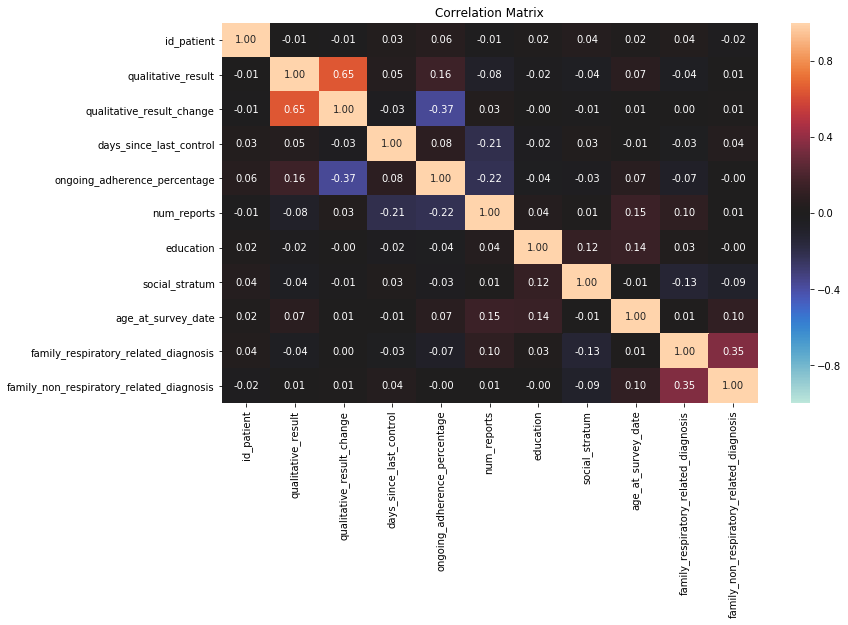

In [16]:
corr_bi_fr_adherence = bi_fr_adherence.corr()
fig, ax = plt.subplots(figsize=(12,7))
sns.heatmap(corr_bi_fr_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

In [17]:
pivoted_life_quality = pd.DataFrame()
for patient, df in life_quality.groupby('id_patient'):
    pvt = df.pivot(index='creation_date', columns='dimension', values='score')
    pvt.columns = pvt.columns.categories
    pvt.reset_index(inplace=True)
    pvt['id_patient'] = patient
    cols = [list(pvt.columns)[-1]] + list(pvt.columns)[:-1]
    pvt = pvt[cols]
    pivoted_life_quality = pivoted_life_quality.append(pvt, ignore_index=True)
#     display(pivoted_life_quality)

pivoted_life_quality.columns = ['id_patient', 'creation_date', 'personal_environment', 'psychological_health', 'interpersonal_relationships', 'physical_health']
pivoted_life_quality['wb_score'] = (pivoted_life_quality['personal_environment'] + pivoted_life_quality['psychological_health'] + pivoted_life_quality['interpersonal_relationships'] + pivoted_life_quality['physical_health']) / 4.
pivoted_life_quality

id_patient creation_date  personal_environment  psychological_health  \
0        502989    2017-01-03                  63.0                  69.0   
1        524006    2015-09-10                  56.0                  69.0   
2        524006    2015-11-18                 100.0                  94.0   
3        524006    2016-03-18                 100.0                  94.0   
4        524006    2016-08-08                 100.0                  94.0   
..          ...           ...                   ...                   ...   
248     1962088    2016-12-20                  63.0                  69.0   
249     1978721    2015-06-02                  63.0                  81.0   
250     1978721    2015-09-14                  69.0                  75.0   
251     1991750    2017-01-13                  81.0                  69.0   
252     1997065    2017-03-13                  81.0                  94.0   

     interpersonal_relationships  physical_health  wb_score  
0                           50.0             63.0     61.25  
1                           44.0             44.0     53.25  
2                           75.0             94.0     90.75  
3                           94.0            100.0     97.00  
4                           94.0            100.0     97.00  
..                           ...              ...       ...  
248                         69.0             31.0     58.00  
249                         56.0             63.0     65.75  
250                         56.0             63.0     65.75  
251                         69.0             63.0     70.50  
252                         69.0             63.0     76.75  

[253 rows x 7 columns]

In [18]:
adherence_change_life_quality = ovu.merge_on_closest_date(df1=adherence_change_analysis, df2=pivoted_life_quality, date_field_df1='survey_date', date_field_df2='creation_date', merge_on='id_patient')
adherence_change_life_quality.rename(columns={'days_since_creation_date': 'days_since_last_well_being_survey'}, inplace=True)

period = 30
aclq_timely = adherence_change_life_quality[adherence_change_life_quality.days_since_last_well_being_survey <= period]
aclq_late = adherence_change_life_quality[adherence_change_life_quality.days_since_last_well_being_survey > period]
aclq_timely

id_patient survey_date category  qualitative_result  \
0        502989  2017-01-03        M                 0.0   
6        524006  2015-09-10       A-                 1.0   
16       524006  2017-08-25       A-                 1.0   
19       535255  2016-12-29        A                 1.0   
20       535255  2017-04-18        A                 1.0   
..          ...         ...      ...                 ...   
939     1941829  2017-03-23        A                 1.0   
940     1941829  2017-03-24        A                 1.0   
947     1978721  2015-10-05        M                 1.0   
954     1991750  2017-01-13        A                 1.0   
958     1997065  2017-03-13        M                 1.0   

     qualitative_result_change  days_since_last_control  \
0                         -1.0                    354.0   
6                          0.0                    248.0   
16                         0.0                     28.0   
19                         0.0                     37.0   
20                         0.0                    110.0   
..                         ...                      ...   
939                        0.0                     34.0   
940                        0.0                      1.0   
947                        0.0                     25.0   
954                        0.0                     38.0   
958                        1.0                    277.0   

     ongoing_adherence_percentage  num_reports  \
0                       25.000000            9   
6                      100.000000            2   
16                      72.727273           12   
19                      90.000000           11   
20                      90.909091           12   
..                            ...          ...   
939                    100.000000            2   
940                    100.000000            3   
947                    100.000000            2   
954                    100.000000            2   
958                     77.777778           10   

     days_since_last_well_being_survey creation_date  personal_environment  \
0                                  0.0    2017-01-03                  63.0   
6                                  0.0    2015-09-10                  56.0   
16                                 1.0    2017-08-24                  75.0   
19                                 0.0    2016-12-29                  69.0   
20                                19.0    2017-03-30                  75.0   
..                                 ...           ...                   ...   
939                               17.0    2017-03-06                  69.0   
940                               18.0    2017-03-06                  69.0   
947                               21.0    2015-09-14                  69.0   
954                                0.0    2017-01-13                  81.0   
958                                0.0    2017-03-13                  81.0   

     psychological_health  interpersonal_relationships  physical_health  \
0                    69.0                         50.0             63.0   
6                    69.0                         44.0             44.0   
16                   56.0                         31.0             50.0   
19                   75.0                         56.0             44.0   
20                   50.0                         69.0             56.0   
..                    ...                          ...              ...   
939                  81.0                         69.0             81.0   
940                  81.0                         69.0             81.0   
947                  75.0                         56.0             63.0   
954                  69.0                         69.0             63.0   
958                  94.0                         69.0             63.0   

     wb_score  
0       61.25  
6       53.25  
16      53.00  
19      61.00  
20      62.50  
..        ...  
939     75.00  
940     

In [19]:
# i = 0
aclq_timely_summary = pd.DataFrame()
for (patient, survey_date), df in aclq_timely.groupby(['id_patient', 'survey_date']):
#     if (df.shape[0] > 1):
#         display(df)
#         i+=1
#         if i > 4:
#             break
    aclq_timely_summary = aclq_timely_summary.append({
        'id_patient': patient,
        'survey_date': survey_date,
        'num_wb_reports_last_30_days': df.shape[0],
        'wb_score': df.iloc[-1]['wb_score'],
        'days_since_last_wb_survey': df.iloc[-1]['days_since_last_well_being_survey']
    }, ignore_index=True)

In [20]:
aclq_timely_summary

days_since_last_wb_survey  id_patient  num_wb_reports_last_30_days  \
0                          0.0    502989.0                          1.0   
1                          0.0    524006.0                          1.0   
2                          1.0    524006.0                          1.0   
3                          0.0    535255.0                          1.0   
4                         19.0    535255.0                          1.0   
..                         ...         ...                          ...   
116                       17.0   1941829.0                          1.0   
117                       18.0   1941829.0                          1.0   
118                       21.0   1978721.0                          1.0   
119                        0.0   1991750.0                          1.0   
120                        0.0   1997065.0                          1.0   

    survey_date  wb_score  
0    2017-01-03     61.25  
1    2015-09-10     53.25  
2    2017-08-25     53.00  
3    2016-12-29     61.00  
4    2017-04-18     62.50  
..          ...       ...  
116  2017-03-23     75.00  
117  2017-03-24     75.00  
118  2015-10-05     65.75  
119  2017-01-13     70.50  
120  2017-03-13     76.75  

[121 rows x 5 columns]

In [54]:
bi_fr_wb_adherence = bi_fr_adherence.merge(aclq_timely_summary, how='left', on=['id_patient', 'survey_date'])

In [55]:
bi_fr_wb_adherence['days_since_last_wb_survey'] = bi_fr_wb_adherence['days_since_last_wb_survey'].fillna(0)
bi_fr_wb_adherence['days_since_last_control'] = bi_fr_wb_adherence['days_since_last_control'].fillna(0)
bi_fr_wb_adherence['num_wb_reports_last_30_days'] = bi_fr_wb_adherence['num_wb_reports_last_30_days'].fillna(0)
bi_fr_wb_adherence['wb_score'] = bi_fr_wb_adherence['wb_score'].fillna(0)
bi_fr_wb_adherence.drop(columns=['qualitative_result_change', 'social_security_regime', 'zone', 'social_security_affiliation_type', 'occupation'], axis=1, inplace=True)

In [56]:
bi_fr_wb_adherence_modelable = bi_fr_wb_adherence.copy()
bi_fr_wb_adherence_modelable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3925 entries, 0 to 3924
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                3925 non-null   int64         
 1   survey_date                               3925 non-null   datetime64[ns]
 2   category                                  3925 non-null   category      
 3   qualitative_result                        3925 non-null   float64       
 4   days_since_last_control                   3925 non-null   float64       
 5   ongoing_adherence_percentage              3925 non-null   float64       
 6   num_reports                               3925 non-null   int64         
 7   gender                                    3925 non-null   category      
 8   education                                 3925 non-null   float64       
 9   civil_status                  

In [57]:
bi_fr_wb_adherence_modelable['category'] = bi_fr_wb_adherence_modelable['category'].cat.codes
# bi_fr_wb_adherence_modelable['gender'] = bi_fr_wb_adherence_modelable['gender'].cat.codes
# bi_fr_wb_adherence_modelable['education'] = bi_fr_wb_adherence_modelable['education'].cat.codes
# bi_fr_wb_adherence_modelable['civil_status'] = bi_fr_wb_adherence_modelable['civil_status'].cat.codes
bi_fr_wb_adherence_modelable['socioeconomic_level'] = bi_fr_wb_adherence_modelable['socioeconomic_level'].cat.codes
# bi_fr_wb_adherence_modelable['occupation'] = bi_fr_wb_adherence_modelable['occupation'].cat.codes
bi_fr_wb_adherence_modelable = pd.get_dummies(bi_fr_wb_adherence_modelable, columns=['gender', 'civil_status', 'employment_type'])

In [58]:
bi_fr_wb_adherence_modelable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3925 entries, 0 to 3924
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                3925 non-null   int64         
 1   survey_date                               3925 non-null   datetime64[ns]
 2   category                                  3925 non-null   int8          
 3   qualitative_result                        3925 non-null   float64       
 4   days_since_last_control                   3925 non-null   float64       
 5   ongoing_adherence_percentage              3925 non-null   float64       
 6   num_reports                               3925 non-null   int64         
 7   education                                 3925 non-null   float64       
 8   social_stratum                            3925 non-null   float64       
 9   socioeconomic_level           

Text(0.5,1,'Correlation Matrix')

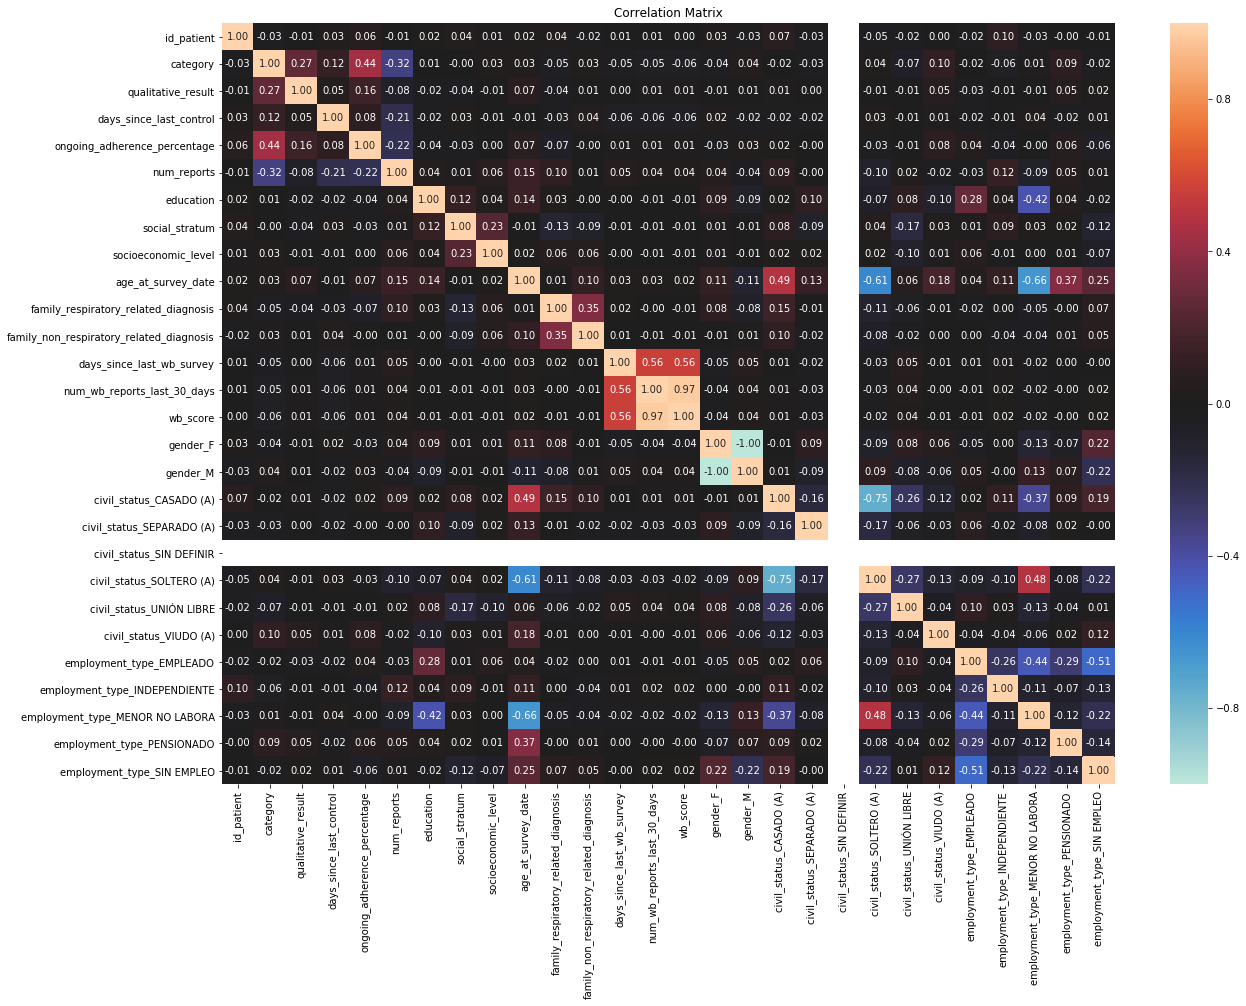

In [59]:
corr_bi_fr_wb_adherence = bi_fr_wb_adherence_modelable.corr()
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr_bi_fr_wb_adherence, annot=True, fmt=".2f", ax=ax, center=0, vmin=-1.0, vmax=1.0)
plt.title("Correlation Matrix")

## All covariates

In [60]:
# Setting Non-adherent label as '1'
bi_fr_wb_adherence_modelable['qualitative_result'] = np.logical_xor(bi_fr_wb_adherence_modelable['qualitative_result'],1).astype(int)

In [61]:
bi_fr_wb_adherence_modelable[bi_fr_wb_adherence_modelable['qualitative_result']==0]

id_patient survey_date  category  qualitative_result  \
0         500547  2019-03-14         4                   0   
1         500547  2019-10-11         4                   0   
2         500547  2019-12-09         4                   0   
3         500547  2020-01-16         4                   0   
4         500547  2020-03-25         4                   0   
...          ...         ...       ...                 ...   
3917     1998401  2016-01-13         3                   0   
3921     1998401  2018-01-29         3                   0   
3922     1999536  2020-02-22         4                   0   
3923     1999629  2018-05-04         4                   0   
3924     1999629  2018-10-08         4                   0   

      days_since_last_control  ongoing_adherence_percentage  num_reports  \
0                       976.0                    100.000000            2   
1                       211.0                    100.000000            3   
2                        59.0                    100.000000            4   
3                        38.0                    100.000000            5   
4                        69.0                    100.000000            6   
...                       ...                           ...          ...   
3917                     99.0                     85.714286            8   
3921                    504.0                     63.636364           12   
3922                    563.0                    100.000000            2   
3923                     28.0                    100.000000            2   
3924                    157.0                    100.000000            3   

      education  social_stratum  socioeconomic_level  ...  \
0           1.0             3.0                    3  ...   
1           1.0             3.0                    3  ...   
2           1.0             3.0                    3  ...   
3           1.0             3.0                    3  ...   
4           1.0             3.0                    3  ...   
...         ...             ...                  ...  ...   
3917        1.0             2.0                    3  ...   
3921        1.0             2.0                    3  ...   
3922        1.0             4.0                    4  ...   
3923        0.0             3.0                    3  ...   
3924        0.0             3.0                    3  ...   

     civil_status_SEPARADO (A)  civil_status_SIN DEFINIR  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
3917                         0                         0   
3921                         0                         0   
3922                         0                         0   
3923                         0                         0   
3924                         0                         0   

      civil_status_SOLTERO (A)  civil_status_UNIÓN LIBRE  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
3                            0                         0   
4                            0                         0   
...                        ...                       ...   
3917                         0                         0   
3921                         0                         0   
3922                         1                         0   
3923                         1                         0   
3924                         1                         0   

      civil_status_VIUDO (A)  employment_type_EMPLEADO  \
0                          0                         1   
1                          0                         1   

In [62]:
depth = 7
covariates1 = bi_fr_wb_adherence_modelable.columns[~bi_fr_wb_adherence_modelable.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate'])]
covariates1

Index(['category', 'days_since_last_control', 'ongoing_adherence_percentage',
       'num_reports', 'education', 'social_stratum', 'socioeconomic_level',
       'age_at_survey_date', 'family_respiratory_related_diagnosis',
       'family_non_respiratory_related_diagnosis', 'days_since_last_wb_survey',
       'num_wb_reports_last_30_days', 'wb_score', 'gender_F', 'gender_M',
       'civil_status_CASADO (A)', 'civil_status_SEPARADO (A)',
       'civil_status_SIN DEFINIR', 'civil_status_SOLTERO (A)',
       'civil_status_UNIÓN LIBRE', 'civil_status_VIUDO (A)',
       'employment_type_EMPLEADO', 'employment_type_INDEPENDIENTE',
       'employment_type_MENOR NO LABORA', 'employment_type_PENSIONADO',
       'employment_type_SIN EMPLEO'],
      dtype='object')

In [63]:
bi_fr_wb_adherence_modelable.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3925 entries, 0 to 3924
Data columns (total 30 columns):
 #   Column                                    Non-Null Count  Dtype         
---  ------                                    --------------  -----         
 0   id_patient                                3925 non-null   int64         
 1   survey_date                               3925 non-null   datetime64[ns]
 2   category                                  3925 non-null   int8          
 3   qualitative_result                        3925 non-null   int64         
 4   days_since_last_control                   3925 non-null   float64       
 5   ongoing_adherence_percentage              3925 non-null   float64       
 6   num_reports                               3925 non-null   int64         
 7   education                                 3925 non-null   float64       
 8   social_stratum                            3925 non-null   float64       
 9   socioeconomic_level           

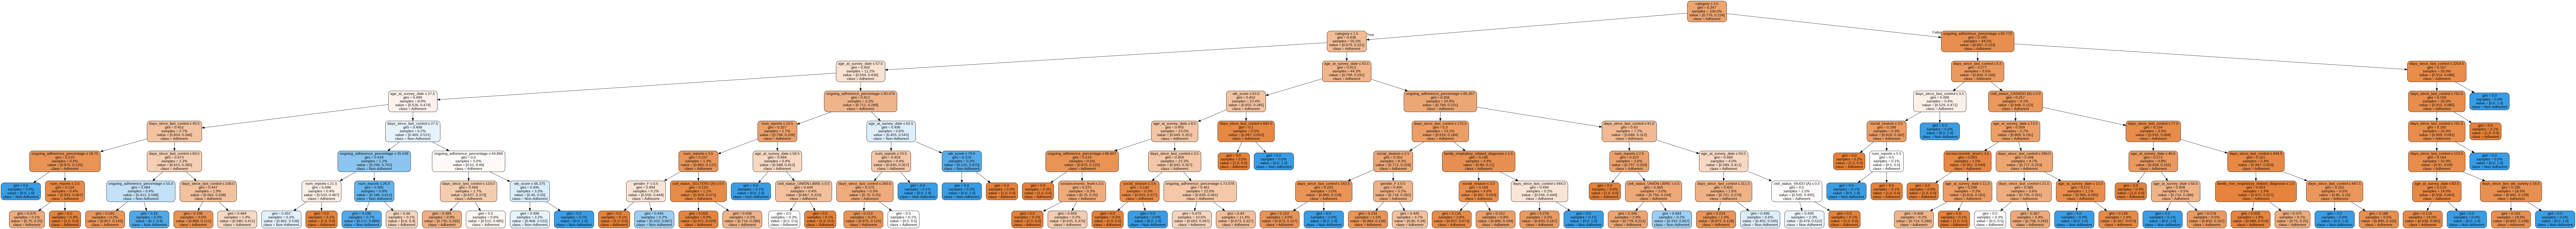

In [64]:
clf = DecisionTreeClassifier(max_depth = depth)

clf = clf.fit(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'])

dot_data = StringIO()
export_graphviz(clf, out_file=dot_data, feature_names = covariates1,
                class_names=['Adherent', 'Non-Adherent'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

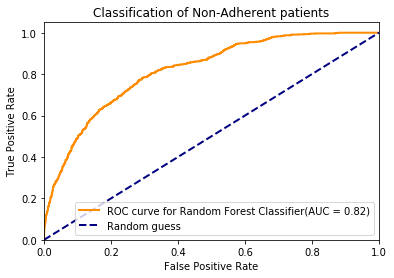

In [65]:
clf_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf.fit(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'])
clf_rf_probas = clf_rf.predict_proba(bi_fr_wb_adherence_modelable[covariates1])

roc_p = roc_curve(bi_fr_wb_adherence_modelable['qualitative_result'], clf_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

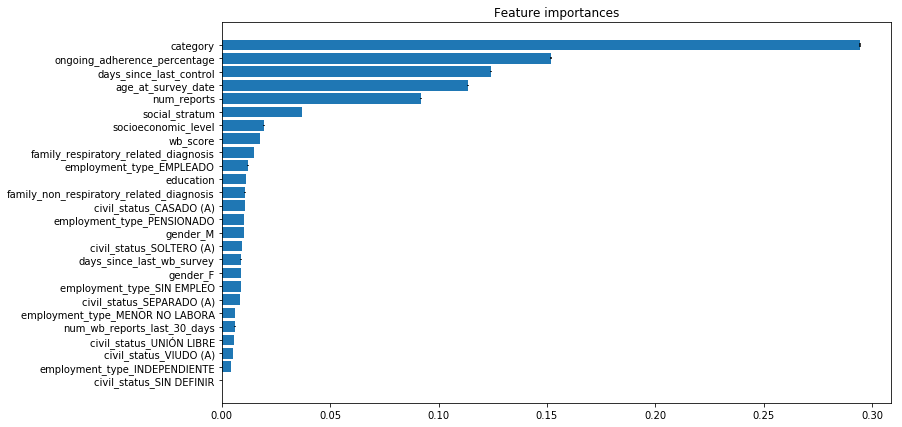

In [66]:
importances = clf_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(bi_fr_wb_adherence_modelable[covariates1].columns[indices], importances[indices], yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

## All covariates except `gender`

In [67]:
covariates2 = bi_fr_wb_adherence_modelable.columns[~bi_fr_wb_adherence_modelable.columns.isin(['id_patient', 'qualitative_result', 'survey_date', 'birthdate'])]#, 'gender_F', 'gender_M'])]
covariates2

Index(['category', 'days_since_last_control', 'ongoing_adherence_percentage',
       'num_reports', 'education', 'social_stratum', 'socioeconomic_level',
       'age_at_survey_date', 'family_respiratory_related_diagnosis',
       'family_non_respiratory_related_diagnosis', 'days_since_last_wb_survey',
       'num_wb_reports_last_30_days', 'wb_score', 'gender_F', 'gender_M',
       'civil_status_CASADO (A)', 'civil_status_SEPARADO (A)',
       'civil_status_SIN DEFINIR', 'civil_status_SOLTERO (A)',
       'civil_status_UNIÓN LIBRE', 'civil_status_VIUDO (A)',
       'employment_type_EMPLEADO', 'employment_type_INDEPENDIENTE',
       'employment_type_MENOR NO LABORA', 'employment_type_PENSIONADO',
       'employment_type_SIN EMPLEO'],
      dtype='object')

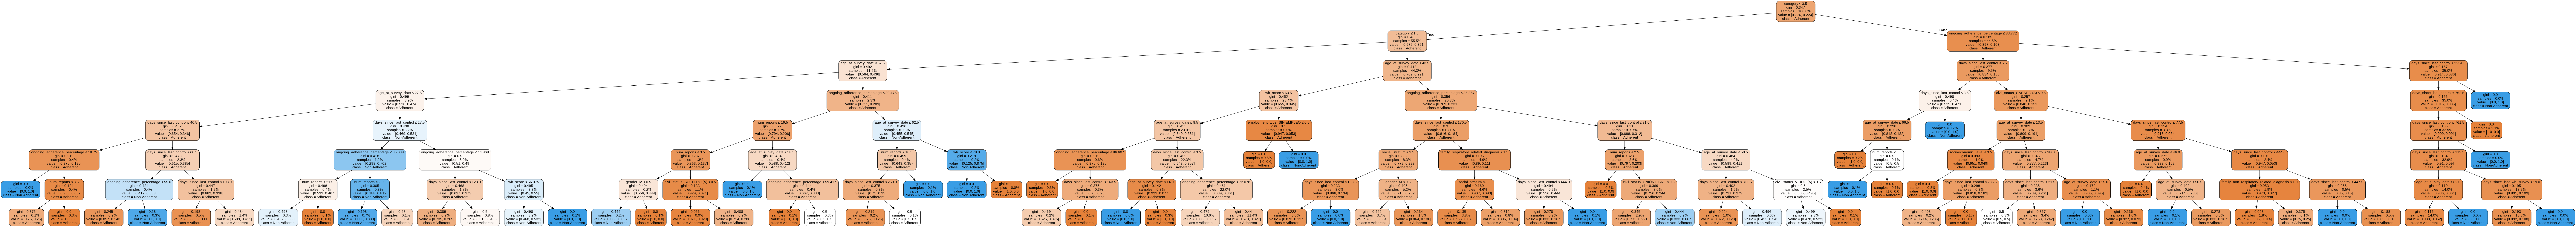

In [68]:
clf2 = DecisionTreeClassifier(max_depth = depth)

clf2 = clf2.fit(bi_fr_wb_adherence_modelable[covariates2], bi_fr_wb_adherence_modelable['qualitative_result'])

dot_data = StringIO()
export_graphviz(clf2, out_file=dot_data, feature_names = covariates2,
                class_names=['Adherent', 'Non-Adherent'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

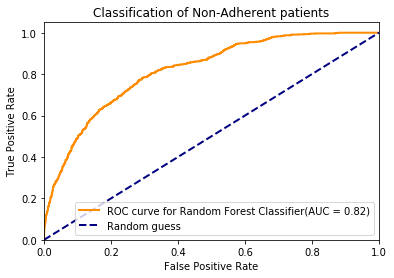

In [69]:
clf2_rf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf2_rf.fit(bi_fr_wb_adherence_modelable[covariates2], bi_fr_wb_adherence_modelable['qualitative_result'])
clf2_rf_probas = clf2_rf.predict_proba(bi_fr_wb_adherence_modelable[covariates2])

roc_p = roc_curve(bi_fr_wb_adherence_modelable['qualitative_result'], clf2_rf_probas[:,1])
auc_p = auc_p = auc( roc_p[0], roc_p[1] )

plt.figure()
line_width = 2
plt.plot(roc_p[0], roc_p[1], color='darkorange', lw=line_width,
         label=f"ROC curve for Random Forest Classifier(AUC = {auc_p:0.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=line_width, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Classification of Non-Adherent patients')
plt.legend(loc='lower right')
plt.show()

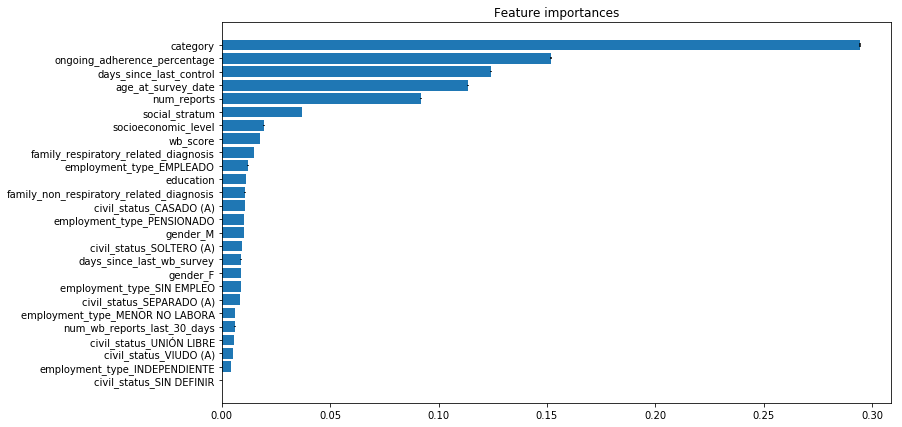

In [70]:
importances = clf2_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf2_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(bi_fr_wb_adherence_modelable[covariates2].columns[indices], importances[indices], yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

## Train and test sets

In [71]:
bi_fr_wb_adherence_train = bi_fr_wb_adherence_modelable[bi_fr_wb_adherence_modelable['survey_date'] < "2020-01-01"]
bi_fr_wb_adherence_test = bi_fr_wb_adherence_modelable[bi_fr_wb_adherence_modelable['survey_date'] > "2019-12-31"]

display(bi_fr_wb_adherence_train)
display(bi_fr_wb_adherence_test)

id_patient survey_date  category  qualitative_result  \
0         500547  2019-03-14         4                   0   
1         500547  2019-10-11         4                   0   
2         500547  2019-12-09         4                   0   
6         502989  2014-10-28         2                   1   
7         502989  2014-11-21         2                   1   
...          ...         ...       ...                 ...   
3919     1998401  2016-06-02         3                   1   
3920     1998401  2016-09-12         3                   1   
3921     1998401  2018-01-29         3                   0   
3923     1999629  2018-05-04         4                   0   
3924     1999629  2018-10-08         4                   0   

      days_since_last_control  ongoing_adherence_percentage  num_reports  \
0                       976.0                    100.000000            2   
1                       211.0                    100.000000            3   
2                        59.0                    100.000000            4   
6                        67.0                      0.000000            2   
7                        24.0                      0.000000            3   
...                       ...                           ...          ...   
3919                    129.0                     77.777778           10   
3920                    102.0                     70.000000           11   
3921                    504.0                     63.636364           12   
3923                     28.0                    100.000000            2   
3924                    157.0                    100.000000            3   

      education  social_stratum  socioeconomic_level  ...  \
0           1.0             3.0                    3  ...   
1           1.0             3.0                    3  ...   
2           1.0             3.0                    3  ...   
6           1.0             3.0                    3  ...   
7           1.0             3.0                    3  ...   
...         ...             ...                  ...  ...   
3919        1.0             2.0                    3  ...   
3920        1.0             2.0                    3  ...   
3921        1.0             2.0                    3  ...   
3923        0.0             3.0                    3  ...   
3924        0.0             3.0                    3  ...   

     civil_status_SEPARADO (A)  civil_status_SIN DEFINIR  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
6                            0                         0   
7                            0                         0   
...                        ...                       ...   
3919                         0                         0   
3920                         0                         0   
3921                         0                         0   
3923                         0                         0   
3924                         0                         0   

      civil_status_SOLTERO (A)  civil_status_UNIÓN LIBRE  \
0                            0                         0   
1                            0                         0   
2                            0                         0   
6                            1                         0   
7                            1                         0   
...                        ...                       ...   
3919                         0                         0   
3920                         0                         0   
3921                         0                         0   
3923                         1                         0   
3924                         1                         0   

      civil_status_VIUDO (A)  employment_type_EMPLEADO  \
0                          0                         1   
1                          0                         1   

id_patient survey_date  category  qualitative_result  \
3         500547  2020-01-16         4                   0   
4         500547  2020-03-25         4                   0   
5         500547  2020-05-08         4                   0   
64        526049  2020-03-06         4                   0   
65        526049  2020-03-19         4                   0   
...          ...         ...       ...                 ...   
3880     1990453  2020-05-06         3                   0   
3892     1995390  2020-04-21         2                   0   
3908     1997065  2020-02-19         2                   0   
3910     1997825  2020-01-16         2                   0   
3922     1999536  2020-02-22         4                   0   

      days_since_last_control  ongoing_adherence_percentage  num_reports  \
3                        38.0                    100.000000            5   
4                        69.0                    100.000000            6   
5                        44.0                    100.000000            7   
64                     1176.0                    100.000000            5   
65                       13.0                    100.000000            6   
...                       ...                           ...          ...   
3880                    168.0                     70.000000           11   
3892                   1091.0                     83.333333            7   
3908                    498.0                     84.615385           14   
3910                    168.0                     50.000000            3   
3922                    563.0                    100.000000            2   

      education  social_stratum  socioeconomic_level  ...  \
3           1.0             3.0                    3  ...   
4           1.0             3.0                    3  ...   
5           1.0             3.0                    3  ...   
64          1.0             3.0                    4  ...   
65          1.0             3.0                    4  ...   
...         ...             ...                  ...  ...   
3880        1.0             2.0                    3  ...   
3892        1.0             3.0                    3  ...   
3908        0.0             3.0                    4  ...   
3910        1.0             3.0                    4  ...   
3922        1.0             4.0                    4  ...   

     civil_status_SEPARADO (A)  civil_status_SIN DEFINIR  \
3                            0                         0   
4                            0                         0   
5                            0                         0   
64                           0                         0   
65                           0                         0   
...                        ...                       ...   
3880                         0                         0   
3892                         0                         0   
3908                         0                         0   
3910                         0                         0   
3922                         0                         0   

      civil_status_SOLTERO (A)  civil_status_UNIÓN LIBRE  \
3                            0                         0   
4                            0                         0   
5                            0                         0   
64                           0                         0   
65                           0                         0   
...                        ...                       ...   
3880                         1                         0   
3892                         0                         0   
3908                         1                         0   
3910                         1                         0   
3922                         1                         0   

      civil_status_VIUDO (A)  employment_type_EMPLEADO  \
3                          0                         1   
4                          0                         1   

#### Decision Tree

Accuracy in training set: 0.7902097902097902
Accuracy in the other samples: 0.8971428571428571


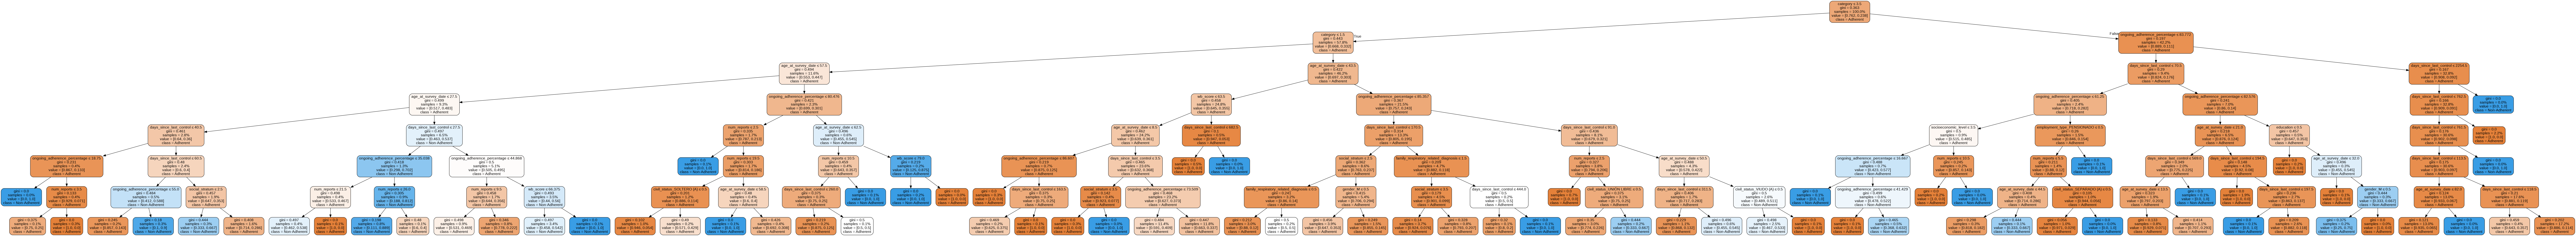

In [72]:
clf_new = DecisionTreeClassifier(max_depth = depth)
clf_new = clf_new.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

y_pred_train = clf_new.predict(bi_fr_wb_adherence_train[covariates2])
y_pred_test = clf_new.predict(bi_fr_wb_adherence_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(bi_fr_wb_adherence_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], y_pred_test)}")
      
dot_data = StringIO()
export_graphviz(clf_new, out_file=dot_data, feature_names = covariates2,
                class_names=['Adherent', 'Non-Adherent'],  
                filled=True, rounded=True,
                special_characters=True, 
                impurity='gini', proportion=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

#### Random Forest

In [73]:
clf_rf_new = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_new.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

y_pred_train = clf_rf_new.predict(bi_fr_wb_adherence_train[covariates2])
y_pred_test = clf_rf_new.predict(bi_fr_wb_adherence_test[covariates2])

print(f"Accuracy in training set: {accuracy_score(bi_fr_wb_adherence_train['qualitative_result'], y_pred_train)}")
print(f"Accuracy in the other samples: {accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], y_pred_test)}")

Accuracy in training set: 0.7737062937062937
Accuracy in the other samples: 0.9257142857142857


In [74]:
clf_rf_full = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
clf_rf_full.fit(bi_fr_wb_adherence_modelable[covariates2], bi_fr_wb_adherence_modelable['qualitative_result'])

y_pred_full = clf_rf_full.predict(bi_fr_wb_adherence_modelable[covariates2])

print(f"Accuracy in the full dataset: {accuracy_score(bi_fr_wb_adherence_modelable['qualitative_result'], y_pred_full)}")

Accuracy in the full dataset: 0.7859872611464969


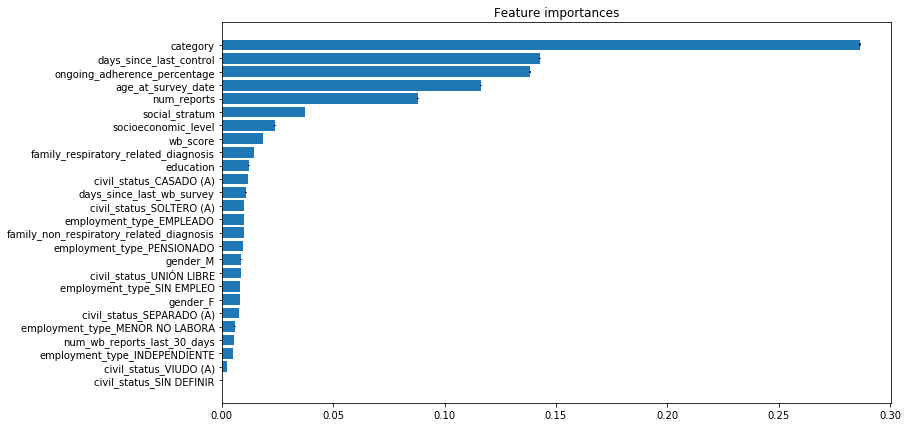

In [75]:
importances = clf_rf_new.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf_rf_new.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the impurity-based feature importances of the forest
plt.figure(figsize=(12,7))
plt.title("Feature importances")
plt.barh(bi_fr_wb_adherence_modelable[covariates2].columns[indices], importances[indices], yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
plt.show()

#### XGBoost

In [76]:
#fit model no training data
xgb_model = XGBClassifier(max_depth=depth, random_state=0, booster='gbtree')
xgb_model.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.300000012, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [77]:
y_pred = xgb_model.predict(bi_fr_wb_adherence_test[covariates2])
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.57%


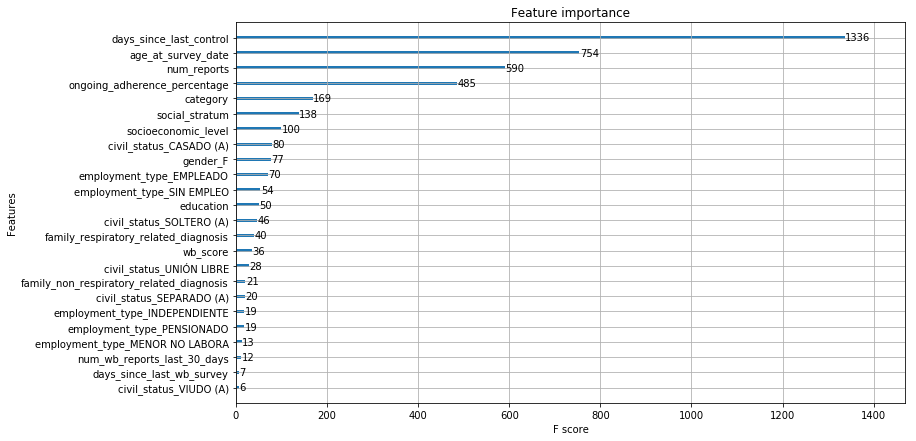

In [78]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax)

In [79]:
params_grid = {  
    'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05],
    'max_depth': [5,6,7,8,9,10,11,12],
    'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 1.0],
    'reg_alpha': [20, 21, 22, 23, 24, 25]
}

search_sk = RandomizedSearchCV(xgb_model, params_grid, cv = 5) # 5 fold cross validation
search_sk.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

# best parameters
print(search_sk.best_params_)
print(search_sk.best_score_)

{'reg_alpha': 23, 'max_depth': 8, 'learning_rate': 0.01, 'gamma': 1.0}
0.7616783216783217


#### XGBoost with the new parameters:

In [80]:
xgb_model_new = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_new.fit(bi_fr_wb_adherence_train[covariates2], bi_fr_wb_adherence_train['qualitative_result'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=1.0, gpu_id=-1,
       importance_type='gain', interaction_constraints='',
       learning_rate=0.01, max_delta_step=0, max_depth=8,
       min_child_weight=1, missing=nan, monotone_constraints='()',
       n_estimators=100, n_jobs=0, num_parallel_tree=1,
       objective='binary:logistic', random_state=0, reg_alpha=23,
       reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
       validate_parameters=1, verbosity=None)

In [81]:
y_pred_new = xgb_model_new.predict(bi_fr_wb_adherence_test[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(bi_fr_wb_adherence_test['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.57%


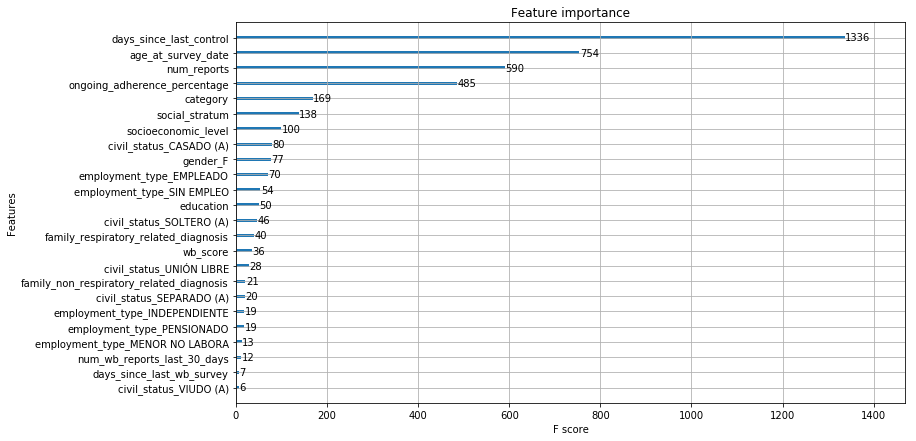

In [82]:
fig, ax = plt.subplots(figsize=(12,7))
xgb.plot_importance(xgb_model, ax=ax)

In [83]:
xgb_model_full = XGBClassifier(random_state=0, booster='gbtree', **search_sk.best_params_)
xgb_model_full.fit(bi_fr_wb_adherence_modelable[covariates2], bi_fr_wb_adherence_modelable['qualitative_result'])

y_pred_new = xgb_model_full.predict(bi_fr_wb_adherence_modelable[covariates2])
predictions_new = [round(value) for value in y_pred_new]

accuracy = accuracy_score(bi_fr_wb_adherence_modelable['qualitative_result'], predictions_new)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 77.63%


## Evaluate these three models with cross validation 

In [84]:
def cv_roc_tree(X, y, n_split, algo='Tree', depth=10, params={}):
    
    cv = StratifiedKFold(n_split)
    
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    for train, test in cv.split(X, y):
        if algo == 'Tree':
            clf = DecisionTreeClassifier()
        elif algo == 'forest':
            clf = RandomForestClassifier(n_estimators=100, max_depth=depth, random_state=0)
        else:
            clf = XGBClassifier(random_state=0, booster='gbtree', verbosity=0, **params)
            
                
        clf = clf.fit(X.iloc[train], y.iloc[train])
        probas_ = clf.predict_proba(X.iloc[test])
        
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y.iloc[test], probas_[:,1])
        tprs.append(np.interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
    
    return tprs, aucs, mean_fpr

Text(0.5,1,'Tree-based Classification of Non-adherent patients: 5-fold Cross-validation')

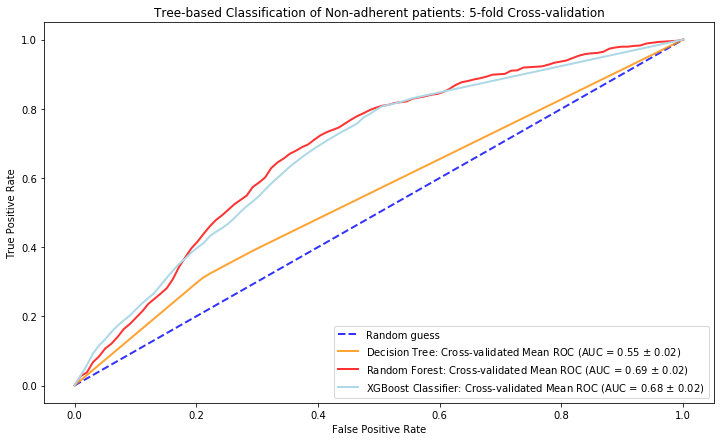

In [85]:
k_folds = 5
tprs_t, aucs_t, mean_fpr_t = cv_roc_tree(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'], k_folds, depth=depth)
tprs_f, aucs_f, mean_fpr_f = cv_roc_tree(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'], k_folds, algo='forest', depth=depth)
tprs_x, aucs_x, mean_fpr_x = cv_roc_tree(bi_fr_wb_adherence_modelable[covariates1], bi_fr_wb_adherence_modelable['qualitative_result'], k_folds, algo='xgboost', params=search_sk.best_params_)

plt.figure(figsize=(12,7))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='blue', label='Random guess', alpha=.8)

mean_tpr_t = np.mean(tprs_t, axis=0)
mean_tpr_f = np.mean(tprs_f, axis=0)
mean_tpr_x = np.mean(tprs_x, axis=0)
mean_tpr_t[-1] = 1.0
mean_tpr_f[-1] = 1.0
mean_tpr_x[-1] = 1.0

mean_auc_t = auc(mean_fpr_t, mean_tpr_t)
mean_auc_f = auc(mean_fpr_f, mean_tpr_f)
mean_auc_x = auc(mean_fpr_x, mean_tpr_x)
std_auc_t = np.std(aucs_t)
std_auc_f = np.std(aucs_f)
std_auc_x = np.std(aucs_x)

plt.plot(mean_fpr_t, mean_tpr_t, color='darkorange', lw=2, alpha=.8,
         label=f"Decision Tree: Cross-validated Mean ROC (AUC = {mean_auc_t:0.2f} $\pm$ {std_auc_t:0.2f})")
plt.plot(mean_fpr_f, mean_tpr_f, color='red', lw=2, alpha=.8,
         label=f"Random Forest: Cross-validated Mean ROC (AUC = {mean_auc_f:0.2f} $\pm$ {std_auc_f:0.2f})")
plt.plot(mean_fpr_x, mean_tpr_x, color='lightblue', lw=2, alpha=1.,
         label=f"XGBoost Classifier: Cross-validated Mean ROC (AUC = {mean_auc_x:0.2f} $\pm$ {std_auc_x:0.2f})")

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title(f'Tree-based Classification of Non-adherent patients: {k_folds}-fold Cross-validation')

### Trying HumanisticModel class

In [ ]:
from humanistic_model import HumanisticModel

hm = HumanisticModel()

# train models
rf, xg = hm.train()

# dump models to disk
hm.dump_models()


#### Loading models from `pkl` files

In [ ]:
import pickle

loaded_rforest = pickle.load(open('human_rforest.pkl','rb'))
loaded_xgboost = pickle.load(open('human_xgboost.pkl','rb'))

In [ ]:
loaded_rforest.predict_proba(bi_fr_wb_adherence_test[covariates2])[:,0]

In [ ]:
loaded_xgboost.predict(bi_fr_wb_adherence_test[covariates2])

In [ ]:
bi_fr_wb_adherence_test['qualitative_result'].to_numpy()

In [ ]:
loaded_xgboost.predict(bi_fr_wb_adherence_test[covariates2])

In [ ]:
bi_fr_wb_adherence_test['qualitative_result'].to_numpy()